In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

def analyze_eigenvalues_and_stability(seed=42):
    """
    Analyze the effect of leak on eigenvalues and system stability
    """
    print("=== Eigenvalue Analysis: Effect of Leak Term ===\n")
    
    # Generate a random matrix J
    np.random.seed(seed)  # For reproducibility
    N = 4
    J = np.random.randn(N, N) * 0.8  # Scale to make some eigenvalues > 1
    
    # Add some structure to make it more interesting
    J = (J + J.T) / 2  # Make symmetric for real eigenvalues
    J += np.random.randn(N, N) * 0.3  # Add some asymmetry
    
    print(f"Matrix J:\n{J}\n")
    
    # Calculate eigenvalues
    eigenvals_J = np.linalg.eigvals(J)
    eigenvals_A = eigenvals_J - 1  # A = J - I, so eigenvalues shift by -1
    
    print("Eigenvalues of J:", eigenvals_J)
    print("Eigenvalues of A = J - I:", eigenvals_A)
    print()
    
    # Check stability conditions
    print("=== Stability Analysis ===")
    
    # For system with leak: dx/dt = (J - I)x
    stable_with_leak = np.all(np.real(eigenvals_A) < 0)
    print(f"System with leak is stable: {stable_with_leak}")
    print(f"Max real part of A eigenvalues: {np.max(np.real(eigenvals_A)):.4f}")
    
    # For system without leak: dx/dt = Jx
    stable_without_leak = np.all(np.real(eigenvals_J) < 0)
    print(f"System without leak is stable: {stable_without_leak}")
    print(f"Max real part of J eigenvalues: {np.max(np.real(eigenvals_J)):.4f}")
    
    print(f"\nStability condition with leak: Re(λ_i) < 1 for all i")
    condition_with_leak = np.all(np.real(eigenvals_J) < 1)
    print(f"Condition satisfied: {condition_with_leak}")
    
    return J, eigenvals_J, eigenvals_A

def simulate_dynamics(J, t_max=5.0, n_trajectories=3, seed=123):
    """
    Simulate and compare dynamics with and without leak
    """
    print(f"\n=== Dynamics Simulation ===")
    
    # Time points - different time spans for different cases
    t_eval_no_leak = np.linspace(0, 20, 1000)  # Shorter time for no leak
    t_eval_leak = np.linspace(0, 100, 1000)    # Longer time for with leak
    
    # Initial conditions
    np.random.seed(seed)
    x0_list = [np.random.randn(J.shape[0]) * 0.5 for _ in range(n_trajectories)]
    
    # Define ODEs
    def ode_with_leak(t, x):
        return (J - np.eye(J.shape[0])) @ x
    
    def ode_without_leak(t, x):
        return J @ x
    
    # Simulate dynamics
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    for i, x0 in enumerate(x0_list):
        # With leak (longer simulation)
        t_leak = t_eval_leak
        dt_leak = t_leak[1] - t_leak[0]
        
        x_leak = np.zeros((len(x0), len(t_leak)))
        x_leak[:, 0] = x0
        
        for j in range(1, len(t_leak)):
            x_leak[:, j] = x_leak[:, j-1] + dt_leak * ode_with_leak(t_leak[j-1], x_leak[:, j-1])
        
        sol_leak = type('obj', (object,), {'t': t_leak, 'y': x_leak})
        
        # Without leak (shorter simulation)
        t_no_leak = t_eval_no_leak
        dt_no_leak = t_no_leak[1] - t_no_leak[0]
        
        try:
            x_no_leak = np.zeros((len(x0), len(t_no_leak)))
            x_no_leak[:, 0] = x0
            
            for j in range(1, len(t_no_leak)):
                x_no_leak[:, j] = x_no_leak[:, j-1] + dt_no_leak * ode_without_leak(t_no_leak[j-1], x_no_leak[:, j-1])
                
                # Check for numerical instability
                if np.any(np.isnan(x_no_leak[:, j])) or np.any(np.abs(x_no_leak[:, j]) > 1e10):
                    x_no_leak[:, j:] = np.inf
                    break
                    
            sol_no_leak = type('obj', (object,), {'t': t_no_leak, 'y': x_no_leak})
        except:
            # If integration fails due to instability, create dummy data
            sol_no_leak = type('obj', (object,), {'t': t_no_leak[:100], 'y': np.ones((len(x0), 100)) * np.inf})
        
        # Plot trajectories
        axes[0].plot(sol_leak.t, np.linalg.norm(sol_leak.y, axis=0), 
                    label=f'Trajectory {i+1}', alpha=0.7)
        
        if not np.any(np.isinf(sol_no_leak.y)):
            axes[1].plot(sol_no_leak.t, np.linalg.norm(sol_no_leak.y, axis=0), 
                        label=f'Trajectory {i+1}', alpha=0.7)
        else:
            axes[1].axhline(y=1000, color=f'C{i}', linestyle='--', alpha=0.7,
                          label=f'Trajectory {i+1} (unstable)')
    
    # Format plots
    axes[0].set_title('With Leak: $\\dot{x} = (J - I)x$ (t_max=100)')
    axes[0].set_xlabel('Time')
    axes[0].set_ylabel('||x(t)||')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    axes[1].set_title('Without Leak: $\\dot{x} = Jx$ (t_max=20)')
    axes[1].set_xlabel('Time')
    axes[1].set_ylabel('||x(t)||')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.savefig('dynamics_comparison.png', dpi=300, bbox_inches='tight')
    
    plt.tight_layout()
    plt.show()

def eigenvalue_visualization(eigenvals_J, eigenvals_A):
    """
    Visualize eigenvalues in the complex plane
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Plot eigenvalues of J
    axes[1].scatter(np.real(eigenvals_J), np.imag(eigenvals_J), 
                   c='red', s=100, alpha=0.7, label='Eigenvalues of J')
    axes[1].axvline(x=0, color='black', linestyle='--', alpha=0.5)
    axes[1].axvline(x=1, color='blue', linestyle='--', alpha=0.5, 
                   label='Stability boundary (Re = 1)')
    axes[1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
    axes[1].set_xlabel('Real Part')
    axes[1].set_ylabel('Imaginary Part')
    axes[1].set_title('Eigenvalues of J')
    axes[1].grid(True, alpha=0.3)
    axes[1].legend()
    
    # Plot eigenvalues of A = J - I
    axes[0].scatter(np.real(eigenvals_A), np.imag(eigenvals_A), 
                   c='blue', s=100, alpha=0.7, label='Eigenvalues of A = J - I')
    axes[0].axvline(x=0, color='red', linestyle='--', alpha=0.5, 
                   label='Stability boundary (Re = 0)')
    axes[0].axhline(y=0, color='black', linestyle='--', alpha=0.5)
    axes[0].set_xlabel('Real Part')
    axes[0].set_ylabel('Imaginary Part')
    axes[0].set_title('Eigenvalues of A = J - I')
    axes[0].grid(True, alpha=0.3)
    axes[0].legend()

    plt.savefig('eigenvalues_comparison.png', dpi=300, bbox_inches='tight')
    
    plt.tight_layout()
    plt.show()

def demonstrate_stability_margin():
    """
    Demonstrate how leak provides stability margin
    """
    print("\n=== Stability Margin Demonstration ===")
    
    # Create matrices with different eigenvalue properties
    cases = [
        ("Stable without leak", np.array([[-0.5, 0.2], [0.1, -0.3]])),
        ("Unstable without leak, stable with leak", np.array([[0.8, 0.3], [0.2, 0.5]])),
        ("Unstable even with leak", np.array([[1.5, 0.4], [0.3, 1.2]]))
    ]
    
    for name, J in cases:
        print(f"\n{name}:")
        eigenvals_J = np.linalg.eigvals(J)
        eigenvals_A = eigenvals_J - 1
        
        print(f"  J eigenvalues: {eigenvals_J}")
        print(f"  A eigenvalues: {eigenvals_A}")
        print(f"  Stable without leak: {np.all(np.real(eigenvals_J) < 0)}")
        print(f"  Stable with leak: {np.all(np.real(eigenvals_A) < 0)}")

=== Eigenvalue Analysis: Effect of Leak Term ===

Matrix J:
[[-0.68509324  0.21976166  0.60935963 -0.5167226 ]
 [-0.09239669  0.28173513 -0.1066843  -0.07856103]
 [ 0.32145645  0.23110639  0.36877289 -0.5103414 ]
 [-0.46758069  0.12564772 -0.41618157  0.10751716]]

Eigenvalues of J: [-0.93474419  0.96358002 -0.18189509  0.22599121]
Eigenvalues of A = J - I: [-1.93474419 -0.03641998 -1.18189509 -0.77400879]

=== Stability Analysis ===
System with leak is stable: True
Max real part of A eigenvalues: -0.0364
System without leak is stable: False
Max real part of J eigenvalues: 0.9636

Stability condition with leak: Re(λ_i) < 1 for all i
Condition satisfied: True


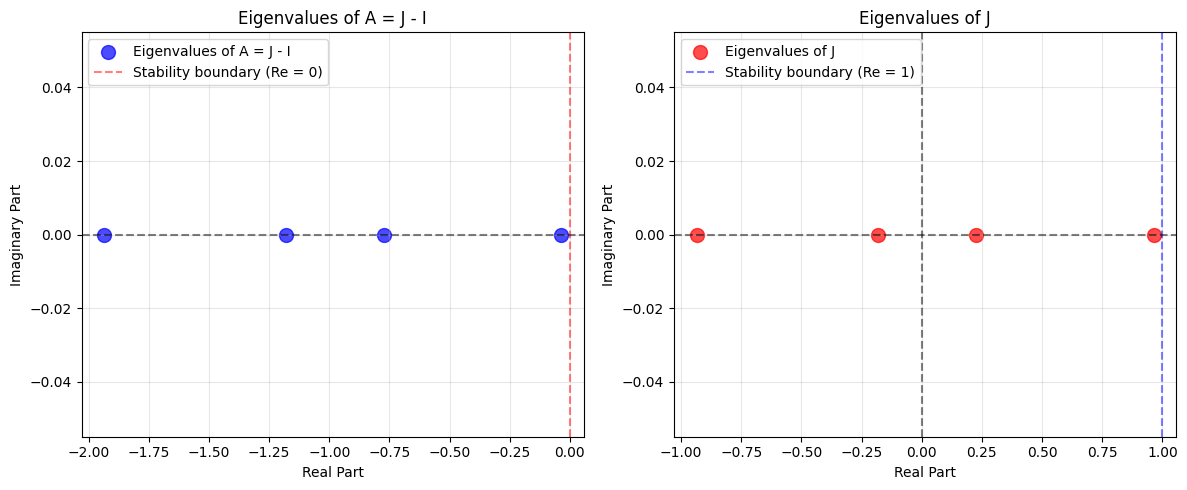


=== Dynamics Simulation ===


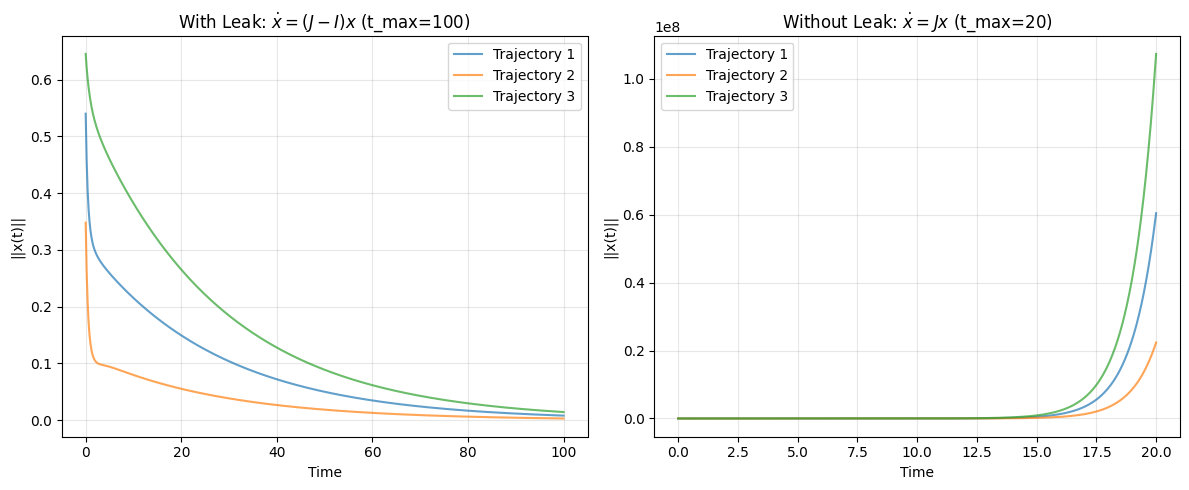


=== Stability Margin Demonstration ===

Stable without leak:
  J eigenvalues: [-0.57320508 -0.22679492]
  A eigenvalues: [-1.57320508 -1.22679492]
  Stable without leak: True
  Stable with leak: True

Unstable without leak, stable with leak:
  J eigenvalues: [0.93722813 0.36277187]
  A eigenvalues: [-0.06277187 -0.63722813]
  Stable without leak: False
  Stable with leak: True

Unstable even with leak:
  J eigenvalues: [1.72749172 0.97250828]
  A eigenvalues: [ 0.72749172 -0.02749172]
  Stable without leak: False
  Stable with leak: False

=== Summary ===
1. Leak term shifts all eigenvalues left by 1 unit
2. Stability condition with leak: Re(λ_i) < 1 for all eigenvalues of J
3. Stability condition without leak: Re(λ_i) < 0 for all eigenvalues of J
4. Leak provides a 'safety margin' of 1 unit in the real part
5. This makes the system more robust to perturbations and modeling errors


In [11]:
# Main analysis
J, eigenvals_J, eigenvals_A = analyze_eigenvalues_and_stability(seed=1000)

# Visualize eigenvalues
eigenvalue_visualization(eigenvals_J, eigenvals_A)


# Simulate dynamics
simulate_dynamics(J, seed=1000, t_max=100.0, n_trajectories=3)

# Demonstrate stability margin concept
demonstrate_stability_margin()

print("\n=== Summary ===")
print("1. Leak term shifts all eigenvalues left by 1 unit")
print("2. Stability condition with leak: Re(λ_i) < 1 for all eigenvalues of J")
print("3. Stability condition without leak: Re(λ_i) < 0 for all eigenvalues of J")
print("4. Leak provides a 'safety margin' of 1 unit in the real part")
print("5. This makes the system more robust to perturbations and modeling errors")